In [4]:
import sys
sys.path.append("..")

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.manifold import SpectralEmbedding, TSNE, MDS
import torch
import umap
from sklearn.preprocessing import StandardScaler
import hdbscan
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 4GB Laptop GPU


## Read data

In [6]:
df = pd.read_csv("extracted_flame_front_120.csv")

# Select meaningful physical variables
#features = ['v', 'T', 'u', 'dudx', 'dudy', 'dvdx', 'dvdy', 'H2',
#       'O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2' ]
# features = ['u', 'v', 'T', 'dudx', 'dudy', 'dvdx', 'dvdy', 'H2',
#        'O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2', 'N2', 'heat_release',
#        'curvature', 'stretch_rate', 'disp_speed_density_weighted',
#        'abs_flame_prop_vel_normal', 'flow_velocity_normal',
#        'flow_velocity_tangential', 'tangential_strain_rate',
#        'normal_strain_rate', 'total_strain_rate', 'density_ratio_sigma',
#        'vorticity', 'omega_H2', 'omega_O2', 'omega_H2O', 'omega_H', 'omega_O',
#        'omega_OH', 'omega_HO2', 'omega_H2O2', 'omega_N2', 'Le_def']
# features = [
#     'omega_H2', 'omega_O2', 'omega_H2O', 'omega_H', 'omega_O', 'omega_OH',
#     'omega_HO2', 'omega_H2O2', 'omega_N2', 'T'
# ]

features = ['T','H2','O2', 'H2O', 'HO2', 'H2O2']

colourmap = df["disp_speed_density_weighted"]

X = StandardScaler().fit_transform(df[features])


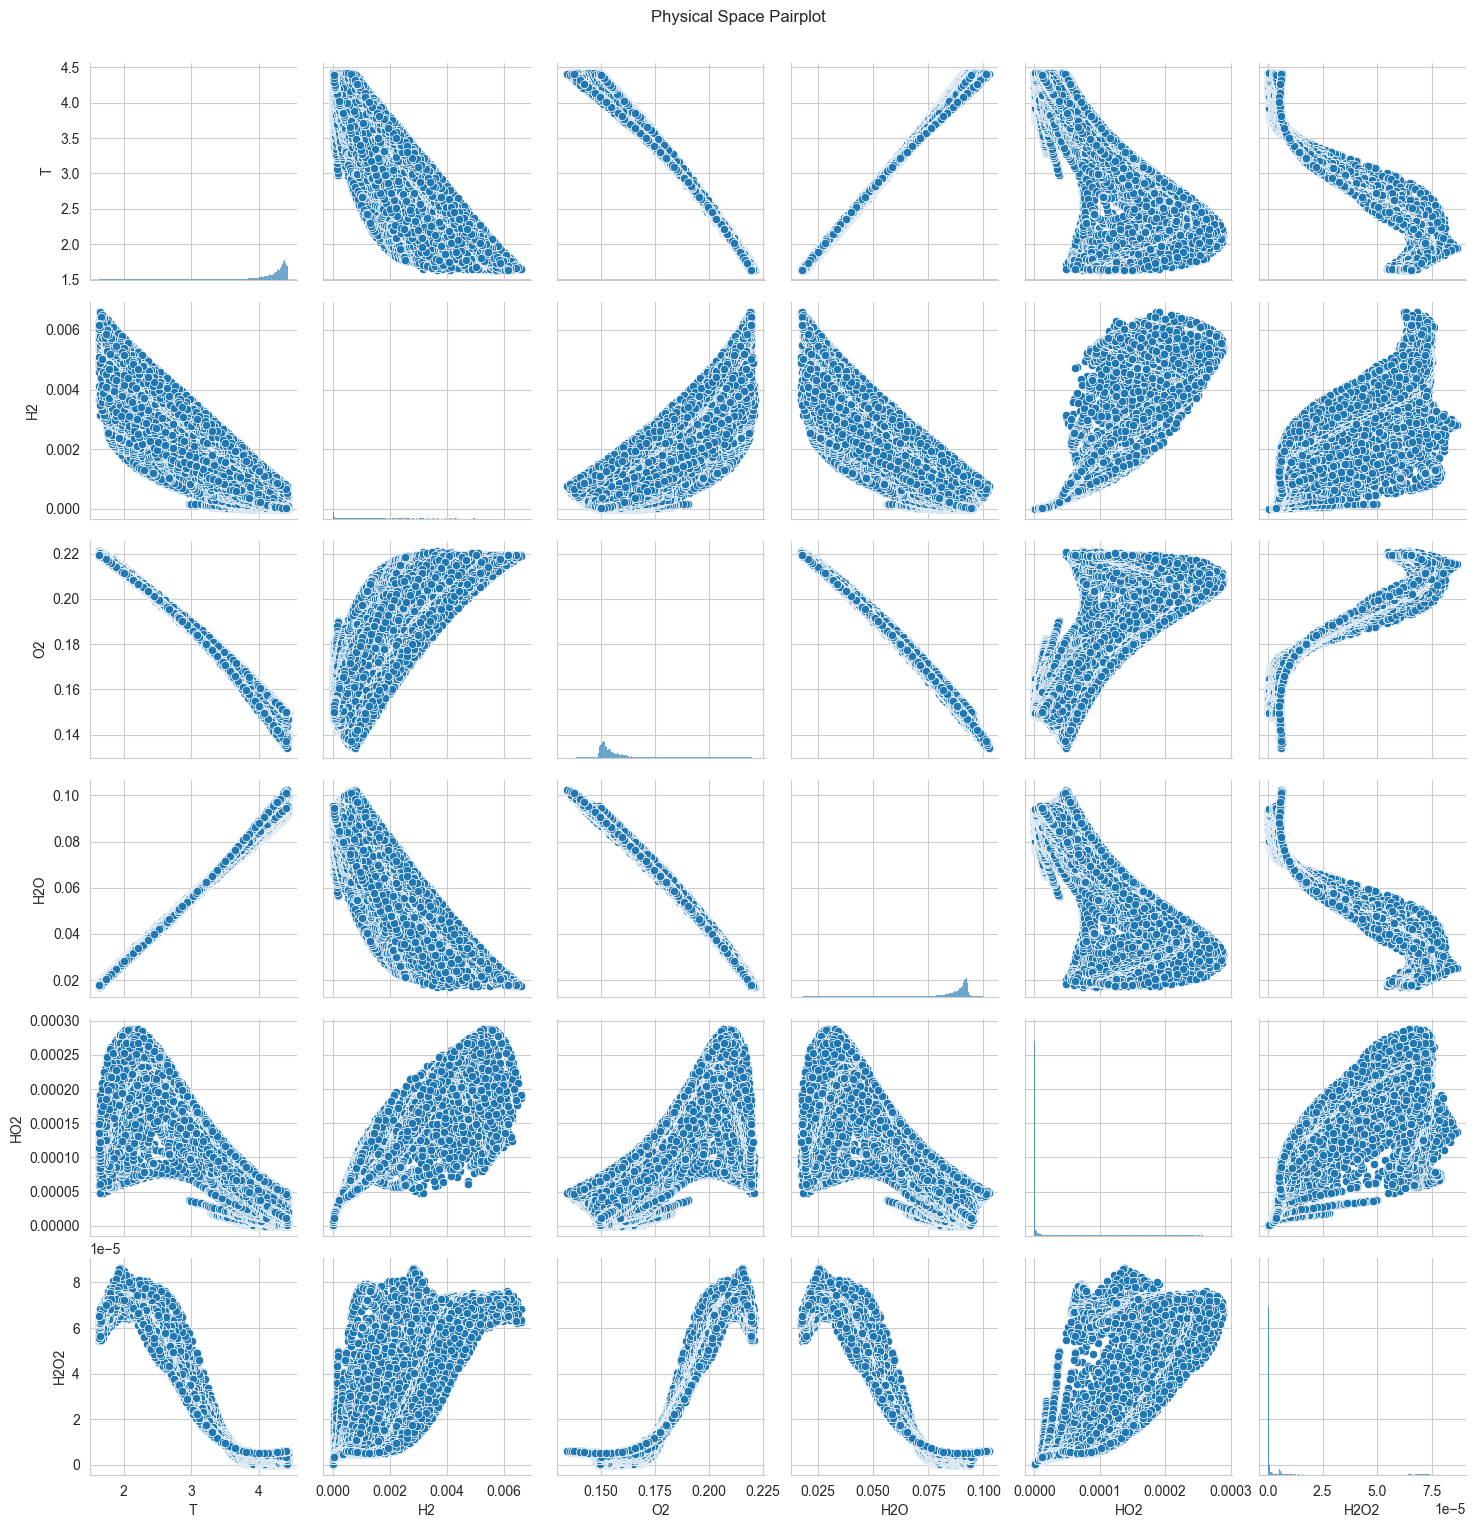

In [4]:
sns.pairplot(df[features])
plt.suptitle('Physical Space Pairplot', y=1.02)
plt.show()

## UMAP

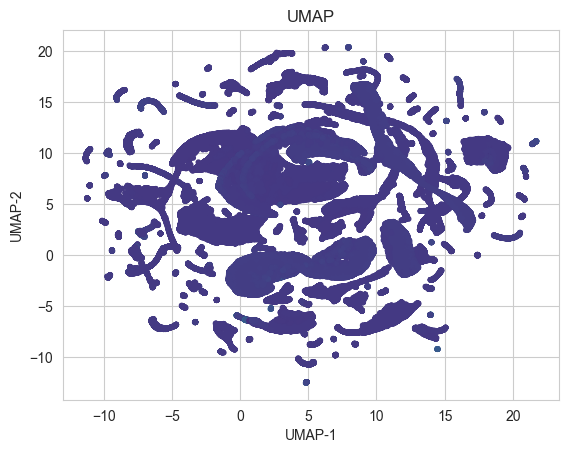

In [5]:
# UMAP embedding
reducer = umap.UMAP(n_neighbors=100, n_components=2 ,init ="random")
X_embedded = reducer.fit_transform(X)
# Plot
plt.scatter(X_embedded[:,0], X_embedded[:,1],c=colourmap, cmap='viridis', s=10)
plt.title("UMAP")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()

## UMAP -> HDBSCAN -> MI -> Mapping to original space
Taken from "Identifying key features in reactive flows: A tutorial on combining
dimensionality reduction, unsupervised clustering, and feature correlation"

## HDBSCAN: Parameter Selection
- min_cluster_size: Smallest allowable grouping
- min_samples: the bigger the more points will be declared as noise

316


C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\alexp\Documents\Bachelor Thesis\Code\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Cluster summary: {np.int64(-1): np.int64(20530), np.int64(0): np.int64(997), np.int64(1): np.int64(341), np.int64(2): np.int64(630), np.int64(3): np.int64(523), np.int64(4): np.int64(409), np.int64(5): np.int64(583), np.int64(6): np.int64(1009), np.int64(7): np.int64(2423), np.int64(8): np.int64(605), np.int64(9): np.int64(595), np.int64(10): np.int64(2665), np.int64(11): np.int64(2190), np.int64(12): np.int64(350), np.int64(13): np.int64(872), np.int64(14): np.int64(504), np.int64(15): np.int64(358), np.int64(16): np.int64(419), np.int64(17): np.int64(4073), np.int64(18): np.int64(1794), np.int64(19): np.int64(786), np.int64(20): np.int64(698), np.int64(21): np.int64(2075), np.int64(22): np.int64(29503), np.int64(23): np.int64(2082), np.int64(24): np.int64(5019), np.int64(25): np.int64(414), np.int64(26): np.int64(4511), np.int64(27): np.int64(2106), np.int64(28): np.int64(2489), np.int64(29): np.int64(205), np.int64(30): np.int64(8482)}
Number of clusters (excluding noise): 31
Noise 

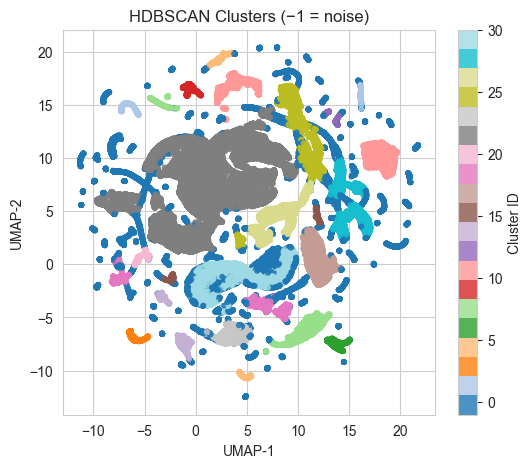

In [6]:
# ============================================================
# HDBSCAN CLUSTERING
# ============================================================

print(int(np.sqrt(len(X))))
clusterer = hdbscan.HDBSCAN(
    min_cluster_size= 200,
    min_samples= 400, #int(np.sqrt(len(X))),
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
).fit(X_embedded)

labels = clusterer.labels_
proba  = clusterer.probabilities_
outlier_scores = clusterer.outlier_scores_

unique, counts = np.unique(labels, return_counts=True)
cluster_summary = dict(zip(unique, counts))
print("Cluster summary:", cluster_summary)
print("Number of clusters (excluding noise):", len(set(labels)) - (1 if -1 in labels else 0))
print("Noise fraction:", np.mean(labels == -1))
print("Average cluster probability:", proba[labels != -1].mean() if np.any(labels != -1) else 0)

# ============================================================
# UMAP SPACE PLOT
# ============================================================
plt.figure(figsize=(6,5))
scatter = plt.scatter(
    X_embedded[:,0], X_embedded[:,1],
    c=labels, cmap='tab20', s=10, alpha=0.8
)
plt.title("HDBSCAN Clusters (−1 = noise)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(scatter, label="Cluster ID")
plt.show()


In [7]:

# ============================================================
# GLOBAL MUTUAL INFORMATION
# ============================================================
from sklearn.feature_selection import mutual_info_regression

mi_x1 = mutual_info_regression(X, X_embedded[:, 0], random_state=0)
mi_x2 = mutual_info_regression(X, X_embedded[:, 1], random_state=0)

df_mi_global = pd.DataFrame({
    'feature': features,
    'MI_dim1': mi_x1,
    'MI_dim2': mi_x2,
    'MI_sum':  mi_x1 + mi_x2
}).sort_values('MI_sum', ascending=False)

print("Global mutual information ranking:")
print(df_mi_global.head(10))
# ============================================================
# PER-CLUSTER MUTUAL INFORMATION
# ============================================================
cluster_labels = sorted(set(labels) - {-1})
mi_cluster = {}

for cluster in cluster_labels:
    mask = labels == cluster
    if mask.sum() < 10:
        continue

    mi1 = mutual_info_regression(X[mask], X_embedded[mask, 0], random_state=0)
    mi2 = mutual_info_regression(X[mask], X_embedded[mask, 1], random_state=0)

    df_new = pd.DataFrame({
        'feature': features,
        'MI_dim1': mi1,
        'MI_dim2': mi2,
        'MI_sum':  mi1 + mi2
    }).sort_values('MI_sum', ascending=False)

    mi_cluster[cluster] = df_new


# Plot top correlations
# for cluster, df_new in mi_cluster.items():
#     top = df_new.head(5)
#     plt.figure(figsize=(5,3))
#     plt.barh(top['feature'][::-1], top['MI_sum'][::-1])
#     plt.xlabel("Mutual Information (sum over dims)")
#     plt.title(f"Cluster {cluster} — Top correlated features")
#     plt.tight_layout()
#     plt.show()



Global mutual information ranking:
  feature   MI_dim1   MI_dim2    MI_sum
0       T  2.893960  2.914031  5.807991
2      O2  2.831674  2.821020  5.652693
3     H2O  2.657405  2.616844  5.274249
5    H2O2  1.480860  1.510444  2.991304
4     HO2  1.267708  1.413745  2.681453
1      H2  0.925371  1.028595  1.953966


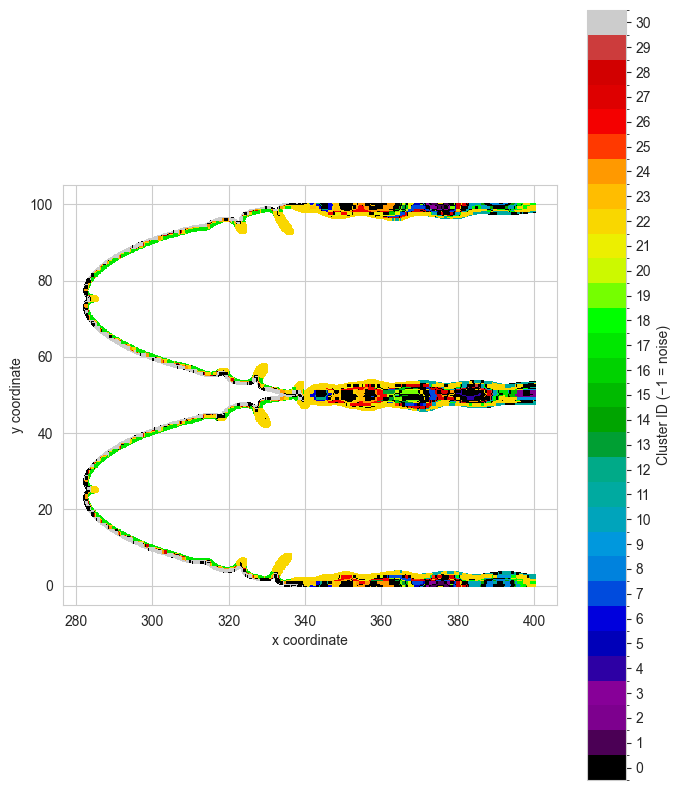

                T            H2        O2       H2O           HO2  \
cluster                                                             
-1       3.949666  4.555345e-04  0.162492  0.080885  2.414948e-05   
 0       4.265170  2.207737e-07  0.154262  0.089439  1.858570e-07   
 1       4.224599  4.506336e-08  0.155600  0.088389  8.416229e-08   
 2       4.356997  3.059642e-08  0.151577  0.091892  5.390045e-08   
 3       4.241129  4.732390e-08  0.155061  0.088749  8.600402e-08   

                 H2O2  
cluster                
-1       7.476966e-06  
 0       1.212549e-07  
 1       7.584517e-08  
 2       3.823724e-08  
 3       7.593509e-08  


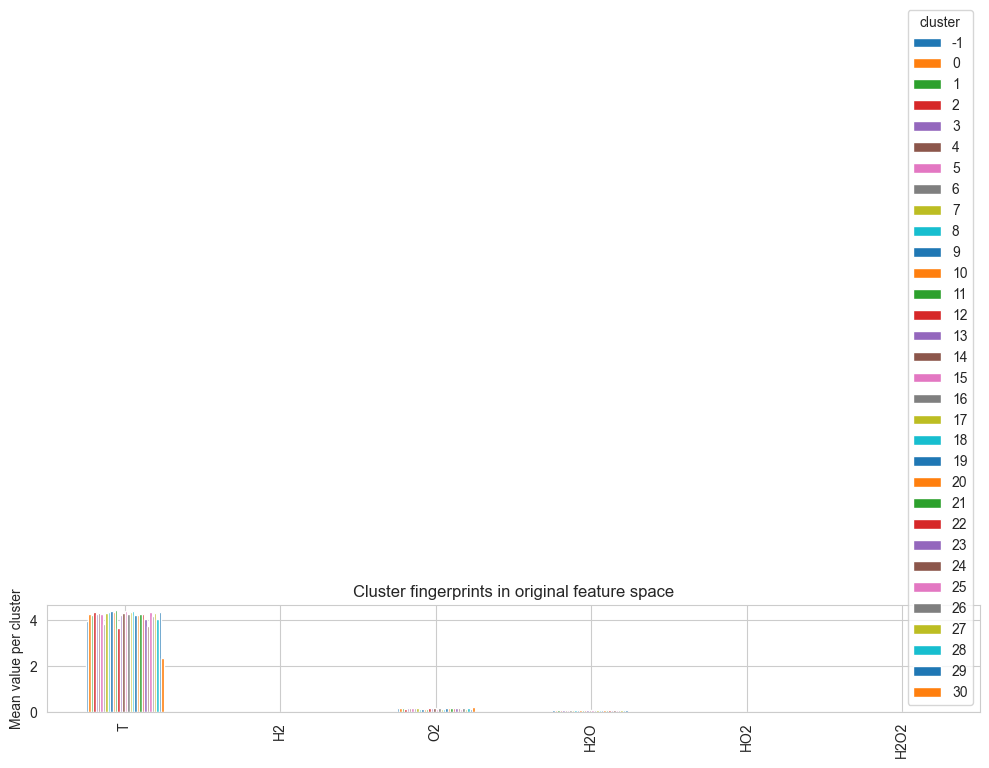

In [8]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.colors import BoundaryNorm
import matplotlib
from scipy.interpolate import griddata
# Discrete bounds: one band per integer label
bounds = np.arange(-0.5, labels.max() + 1.5, 1)
cmap = matplotlib.colormaps['nipy_spectral']
norm = BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(7, 8))

sc = plt.scatter(
    df['x'],
    df['y'],
    c=labels,
    cmap=cmap,
    norm=norm,
    s=5,         # adjust marker size as you like
    marker='s',  # square markers give a more "continuous" feel
    linewidths=0
)

cb = plt.colorbar(sc, ticks=np.arange(labels.min(), labels.max() + 1))
cb.set_label("Cluster ID (−1 = noise)")

plt.xlabel("x coordinate")
plt.ylabel("y coordinate")
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

# ============================================================
# STATISTICS + FINGERPRINTS
# ============================================================
df_with_labels = df.copy()
df_with_labels["cluster"] = labels

cluster_means = df_with_labels.groupby("cluster")[features].mean()
cluster_stds  = df_with_labels.groupby("cluster")[features].std()

print(cluster_means.head())

cluster_means.T.plot(kind='bar', figsize=(10,5))
plt.ylabel("Mean value per cluster")
plt.title("Cluster fingerprints in original feature space")
plt.tight_layout()
plt.show()


## PCA: Chemichal State vs Reaction rates

[State-space features (φ)] Centroids in original feature units:
 [[5.11234257e-07 1.52922945e-01 9.00753735e-02 1.72406619e-08
  3.30374080e-06 5.48853542e-05 3.34471412e-07 1.81372771e-07]
 [1.32732395e-03 1.62278245e-01 7.93086343e-02 4.35409941e-05
  6.27029187e-04 5.87528583e-04 8.21799493e-05 6.90815924e-06]
 [4.34969813e-03 2.08769355e-01 3.14217083e-02 1.64277742e-06
  8.05342572e-06 2.43838497e-05 1.98212901e-04 6.59065146e-05]
 [2.39753737e-03 1.85322095e-01 5.74827206e-02 1.63162528e-05
  1.47702270e-04 1.62519904e-04 1.54947398e-04 2.88017746e-05]
 [6.82158667e-04 1.46222070e-01 9.35060442e-02 6.49466387e-05
  1.13480923e-03 1.22916805e-03 5.16137457e-05 5.46807346e-06]
 [7.47274597e-05 1.63520995e-01 8.03301083e-02 1.69166388e-06
  7.49812383e-05 1.85962507e-04 1.36931367e-05 3.80473243e-06]]

[State-space features (φ)] Feature contributions to first two PCs:
           PC1       PC2
H2O   0.204560  0.006158
H2    0.201891  0.002563
H2O2  0.201523  0.000990
O2    0.199292  

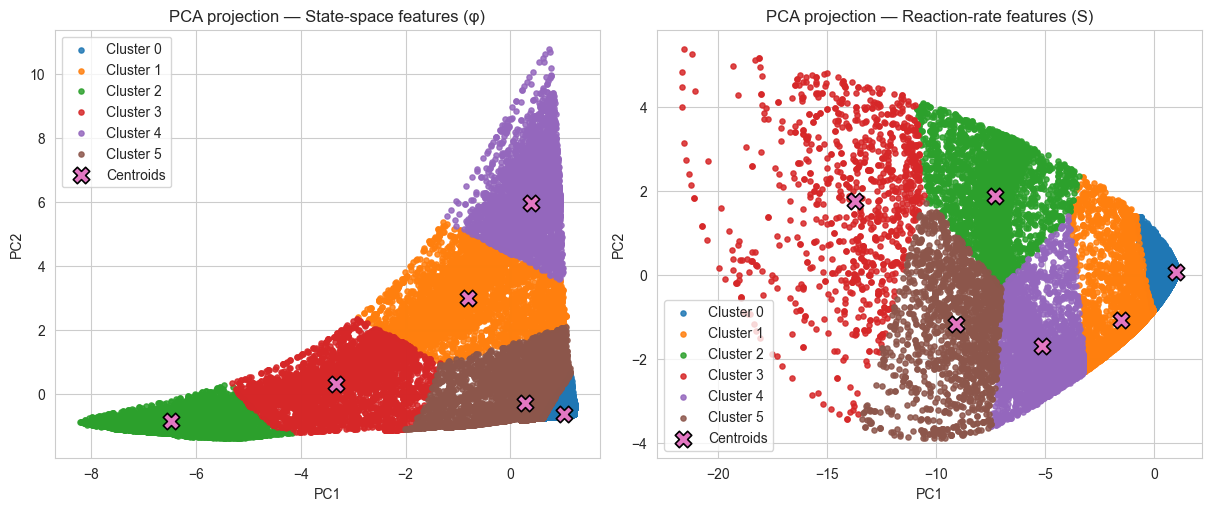

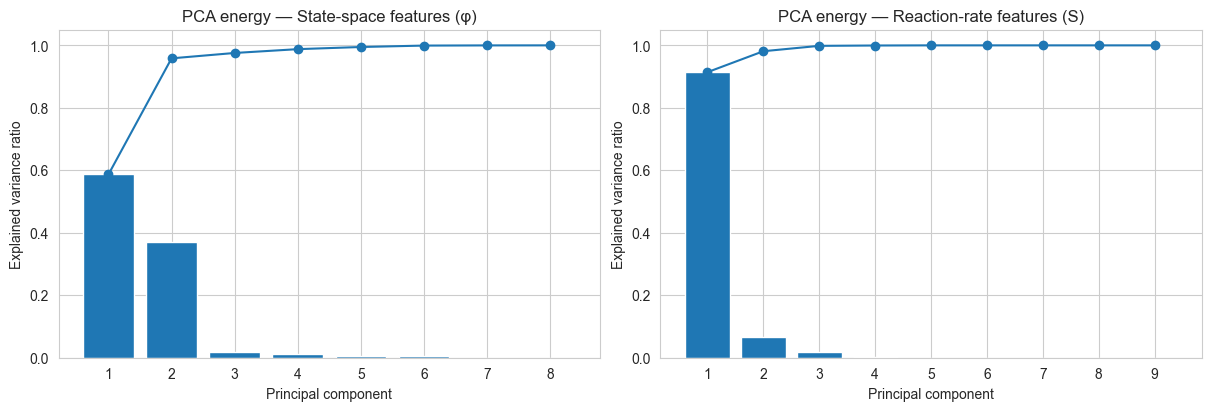

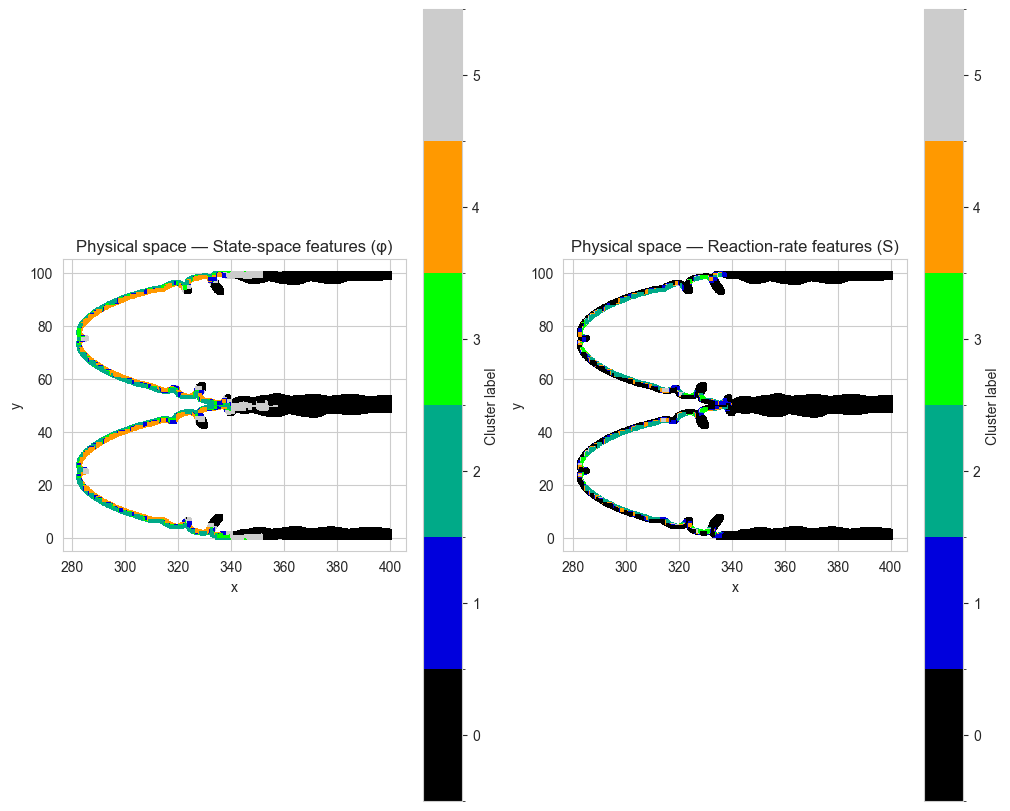

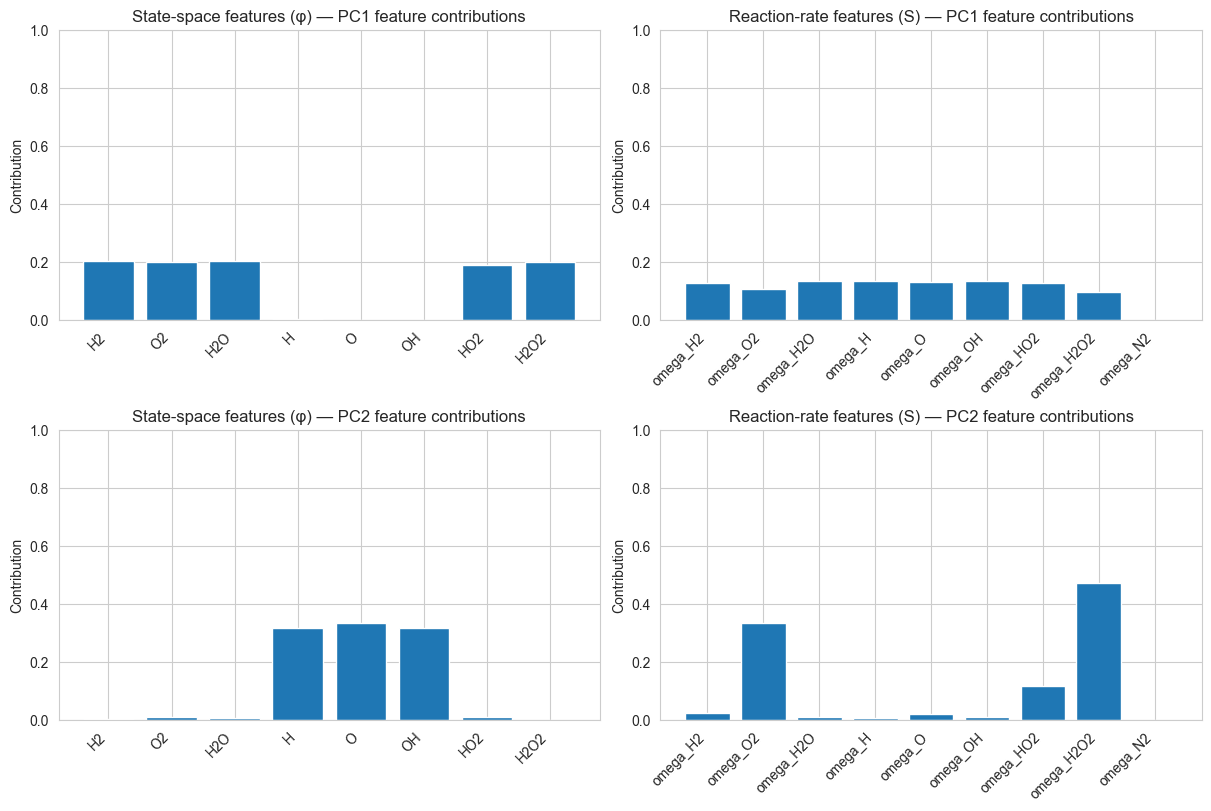

In [8]:
from sklearn.decomposition import PCA
# --- Pre-create side-by-side figures (left=state features, right=rate features) ---
fig_pca,   axs_pca   = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
fig_scree, axs_scree = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
fig_phys,  axs_phys  = plt.subplots(1, 2, figsize=(10, 8), constrained_layout=True)

col_titles = {0: "State-space features (φ)", 1: "Reaction-rate features (S)"}

import matplotlib.tri as mtri
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib as mat

# Triangulation of fixed physical coordinates (reuse for both feature settings)
tri = mtri.Triangulation(df['x'].to_numpy(), df['y'].to_numpy())
fig_load, axs_load = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)
# rows: PCs (PC1, PC2); columns: feature settings (0=state, 1=rate)

for feature_setting in range(2):
    if feature_setting == 0:
        features = [
            'H2', 'O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2'
        ]
    else:
        features = [
            'omega_H2', 'omega_O2', 'omega_H2O', 'omega_H', 'omega_O', 'omega_OH',
            'omega_HO2', 'omega_H2O2', 'omega_N2'
        ]

    X_raw = df[features].to_numpy()
    k = 6
    pipe = make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        KMeans(n_clusters=k, init="k-means++", n_init="auto", max_iter=300, random_state=0)
    )
    labels = pipe.fit_predict(X_raw)

    # Pull out scaler and centroids (centroids are in scaled space)
    scaler = pipe.named_steps["standardscaler"]
    centroids_scaled   = pipe.named_steps["kmeans"].cluster_centers_
    centroids_unscaled = scaler.inverse_transform(centroids_scaled)
    print(f"[{col_titles[feature_setting]}] Centroids in original feature units:\n", centroids_unscaled)

    # Optional: quality metric
    X_scaled = scaler.transform(X_raw)

    # ===== PCA for visualization (fit on scaled data seen by KMeans) =====
    pca = PCA(n_components=None, random_state=0)
    X2d        = pca.fit_transform(X_scaled)            # (n, >=2)
    centroids2d = pca.transform(centroids_scaled)       # centroids in scaled space
    # ===== Feature contributions to PC1 and PC2 =====
    # pca.components_: shape (n_components, n_features)
    # row i -> ith PC, entries -> loading on each feature
    loadings = pca.components_[:2, :]  # take first two PCs

    # Squared loadings as contribution measure, normalized to sum=1 per PC
    contrib = loadings**2
    contrib = contrib / contrib.sum(axis=1, keepdims=True)

    # Nicely formatted table using pandas
    contrib_df = pd.DataFrame(
        contrib,
        index=["PC1", "PC2"],
        columns=features
    )

    print(f"\n[{col_titles[feature_setting]}] Feature contributions to first two PCs:")
    print(contrib_df.T.sort_values("PC1", ascending=False))  # sorted by PC1 (or remove sort)
        # Bar plots for contributions: row=PC, col=feature_setting
    for pc_idx, pc_name in enumerate(["PC1", "PC2"]):
        ax_l = axs_load[pc_idx, feature_setting]
        ax_l.bar(np.arange(len(features)), contrib[pc_idx])
        ax_l.set_xticks(np.arange(len(features)))
        ax_l.set_xticklabels(features, rotation=45, ha="right")
        ax_l.set_ylabel("Contribution")
        ax_l.set_ylim(0, 1)
        ax_l.set_title(f"{col_titles[feature_setting]} — {pc_name} feature contributions")

    evr     = pca.explained_variance_ratio_
    cum_evr = np.cumsum(evr)
    print(f"\n[{col_titles[feature_setting]}] Explained variance ratio per component:")
    for i, (e, c) in enumerate(zip(evr, cum_evr), start=1):
        print(f"  PC{i:>2}: {e:7.4f}   (cumulative: {c:7.4f})")

    # ===== Plot A: PCA clusters (side-by-side) =====
    axp = axs_pca[feature_setting]
    for c in range(k):
        axp.scatter(
            X2d[labels == c, 0], X2d[labels == c, 1],
            s=14, alpha=0.85, label=f"Cluster {c}"
        )
    axp.scatter(
        centroids2d[:, 0], centroids2d[:, 1],
        s=140, marker="X", edgecolor="k", linewidths=1.2, label="Centroids"
    )
    axp.set_title(f"PCA projection — {col_titles[feature_setting]}")
    axp.set_xlabel("PC1")
    axp.set_ylabel("PC2")
    axp.legend(loc="best")

    # ===== Plot B: Scree (side-by-side) =====
    axs = axs_scree[feature_setting]
    idx = np.arange(1, len(evr) + 1)
    axs.bar(idx, evr)
    axs.plot(idx, cum_evr, marker="o")
    axs.set_title(f"PCA energy — {col_titles[feature_setting]}")
    axs.set_xlabel("Principal component")
    axs.set_ylabel("Explained variance ratio")
    axs.set_xticks(idx)

    # ===== Plot C: Physical x–y map (side-by-side) — continuous categorical fill =====
    # --- choose a categorical colormap with exactly k distinct colors ---
    cmap = mat.colormaps.get_cmap('nipy_spectral')
    # --- discrete boundaries so each integer label maps to one color band ---
    bounds = np.arange(-0.5, k + 0.5, 1)
    norm   = BoundaryNorm(bounds, cmap.N)

    z = labels  # cluster labels (length n)

    # >>>>> USE PRE-CREATED AXIS <<<<<
    ax_phys = axs_phys[feature_setting]  # use pre-created axis instead of new figure

    # Scatter version (instead of tricontourf)
    # x, y must be your point coordinates of length n
    c = ax_phys.scatter(
        df['x'],
        df['y'],
        c=z,
        cmap=cmap,
        norm=norm,
        s=8,         # adjust marker size as you like
        marker='s',  # 's' gives a more "pixel-like" continuous feel; use 'o' if preferred
        linewidths=0
    )

    # Attach colorbar to fig_phys, but only for this axis
    cb = fig_phys.colorbar(c, ax=ax_phys, ticks=np.arange(k))
    cb.set_label("Cluster label")

    ax_phys.set_xlabel("x")
    ax_phys.set_ylabel("y")
    ax_phys.set_title(f"Physical space — {col_titles[feature_setting]}")
    ax_phys.set_aspect("equal")  # optional but usually nice for x–y maps


# --- Render all figures once, side-by-side comparisons ready ---
plt.show()
fig_load.suptitle("Feature contributions to first two PCs", fontsize=14)
plt.show()



## Spectral Embedding

In [ ]:
SE = SpectralEmbedding(n_components=2, n_neighbors=30)
X_SE = SE.fit_transform(X)
# Plot
plt.scatter(X_SE[:, 0], X_SE[:, 1], c=colourmap, cmap='viridis', s=10)
plt.title("Spectral Embedding")
plt.xlabel("SE-1")
plt.ylabel("SE-2")
plt.show()

## t-SNE

In [ ]:
t_sne = TSNE(
    n_components=2,
    perplexity=30,
    init="random",
    max_iter=250,
    random_state=0,
)
X_sne = t_sne.fit_transform(X)

plt.scatter(X_sne[:,0], X_sne[:,1],c=colourmap, cmap='viridis', s=10)
plt.title("t-SNE")
plt.xlabel("t_SNE-1")
plt.ylabel("t_SNE-2")
plt.show()

## Mutidimensional Scaling

In [15]:
mds_embedding = MDS(n_components=2, n_init=1)
X_mds = mds_embedding.fit_transform(X)

plt.scatter(X_mds[:,0], X_mds[:,1],c=colourmap, cmap='viridis', s=10)
plt.title("MDS")
plt.xlabel("MDS-1")
plt.ylabel("MDS-2")
plt.show()

MemoryError: Unable to allocate 74.9 GiB for an array with shape (100240, 100240) and data type float64